In [4]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import torch
import random
from IPython.display import clear_output
from visualize import render_points, render_transforms, render_gif
from ifs import iterate
from markov import weighted_random_chooser, determinant_probabilities
from catalogue.leaves import FERN2D, MAPLE2D
from objective import hutchinson, collage_loss
from geomloss import SamplesLoss

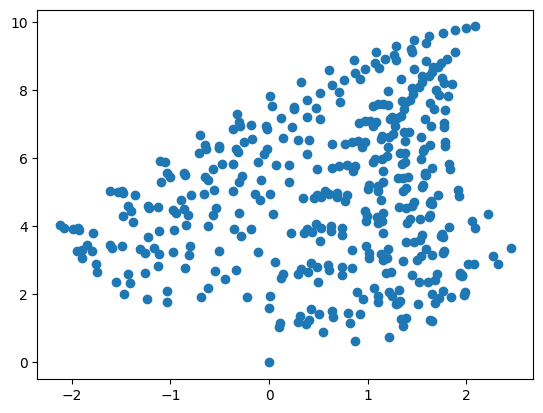

In [5]:
target_points = iterate(weighted_random_chooser(FERN2D), num_iters=400)
plt.clf()
plt.scatter(target_points.T[0], target_points.T[1])
plt.show()

In [6]:
#conformal affine
def random_affine():
    return torch.cat([
        torch.rand(2) * torch.tensor([np.pi * 2, 1]),
        torch.randn(2) / 2
    ]) # rotate, scale, dx, dy


def affine_to_matrix(a):
    out = torch.zeros(3, 3)
    out[0, 0] = a[1] * a[0].cos()
    out[0, 1] = a[1] * -a[0].sin()
    out[1, 0] = a[1] * a[0].sin()
    out[1, 1] = a[1] * a[0].cos()
    out[0, 2] = a[2]
    out[1, 2] = a[3]
    out[2, 2] = 1.
    return out

def chamfer(A, B): # A = target, B = trace
    assert A.shape[1] == 2
    assert B.shape[1] == 2
    
    dists = ((A.unsqueeze(0) - B.unsqueeze(1)) ** 2).sum(dim=2)
    
    mins_a = torch.min(dists, dim=0).values
    mins_b = torch.min(dists, dim=1).values
    return mins_a.mean() + mins_b.mean()

sinkhorn_distance = SamplesLoss(loss='sinkhorn', p=1, blur=0.05, backend='tensorized', scaling = 0.5, verbose=True)

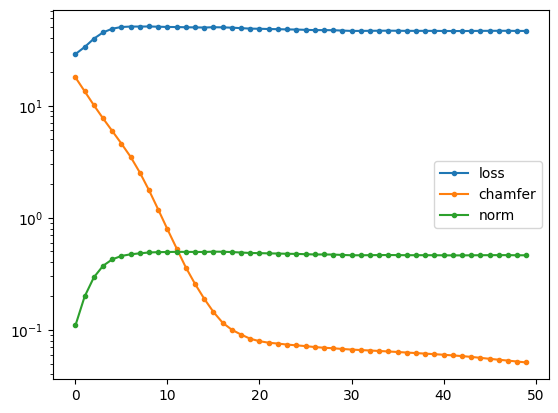

In [23]:
N = 3
F_ = [random_affine() for i in range(N)]

for f in F_:
    f.requires_grad_()
o = torch.optim.Adam(F_, lr=0.001)


losses = []
history = []
chamfer_history = []
norm_history = []

sample_target = torch.tensor(target_points, dtype=torch.float)
for step in range(5_000):
    o.zero_grad()
    
    v = torch.tensor([0., 0., 1.])
    trace = []
    
    F = [affine_to_matrix(a) for a in F_]
    """fate = [random.randrange(len(F)) for _ in range(400)]
    for f in fate:
        v = torch.matmul(F[f], v)
        trace.append(v)

    trace = torch.stack(trace)[:, :2]
    
    loss = chamfer(sample_target, trace)"""
    loss, chamfer, norm = collage_loss(transforms=F, target=sample_target, a1=1, a2=0, decomp=True)
    loss.backward()
    o.step()
    
    if step % 100 == 0:
        losses.append(loss.detach().item())
        history.append(F)
        chamfer_history.append(chamfer.detach().item())
        norm_history.append(norm.detach().item())
        """clear_output(wait=True)
        trace_ = trace.detach().numpy()
        plt.title('iter = %d and loss = %f' % (step, loss.detach().item()))
        plt.axis('equal')
        plt.imshow(~img, extent=(-0.5, 0.5, -0.5, 0.5))
        plt.plot(trace_[:, 0], trace_[:, 1], 'k+')
        plt.savefig('out/%010d.jpg' % step)
        plt.show()"""
        
plt.figure()
plt.plot(losses, '.-', label='loss')
plt.plot(chamfer_history, '.-', label='chamfer')
plt.plot(norm_history, '.-', label='norm')
plt.legend()
plt.yscale('log')
plt.show()

[[[-3.7932807e-07  2.4669857e-06 -1.4080098e-05]
  [-2.4669857e-06 -3.7932807e-07  4.3630134e-06]
  [ 0.0000000e+00  0.0000000e+00  1.0000000e+00]]

 [[-2.0416809e-11 -2.7081937e-11  1.7936866e-10]
  [ 2.7081937e-11 -2.0416809e-11  9.1273343e-11]
  [ 0.0000000e+00  0.0000000e+00  1.0000000e+00]]

 [[ 1.0055833e+00  1.6836008e-01 -1.0491935e+00]
  [-1.6836008e-01  1.0055833e+00  1.9063734e-01]
  [ 0.0000000e+00  0.0000000e+00  1.0000000e+00]]]


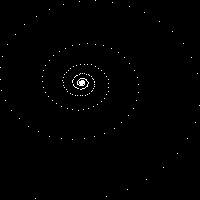

In [26]:
F = np.array([affine_to_matrix(a).detach() for a in F_])
print(F)
pred_points = iterate(weighted_random_chooser(F), 10_000)
render_points(pred_points, dim=(200,200))

In [25]:
ifs_history = [np.array([f.detach().numpy() for f in ifs]) for ifs in history]
_ = render_gif([iterate(weighted_random_chooser(ifs), 10_000) for ifs in ifs_history], fpath='attractor_history.gif', image_mode=False)

/Users/olivertoh/Documents/IFS-NN/IFSPy/affine.py:23: RuntimeWarning: overflow encountered in matmul
  return (transform@point)[:2]
/Users/olivertoh/Documents/IFS-NN/IFSPy/affine.py:23: RuntimeWarning: invalid value encountered in matmul
  return (transform@point)[:2]
Rendering...:   0%|          | 0/50 [00:00<?, ?it/s]/Users/olivertoh/Documents/IFS-NN/IFSPy/visualize.py:38: RuntimeWarning: invalid value encountered in cast
  floored_pixels = np.floor(pixels).astype(int)
Rendering...: 100%|██████████| 50/50 [00:00<00:00, 118.75it/s]


In [73]:
_ = render_gif([render_transforms(ifs) for ifs in ifs_history], fpath='ifs_history.gif', image_mode=True)

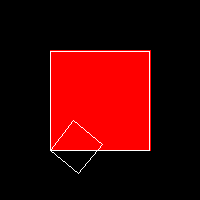

In [10]:
render_transforms([f for f in F])

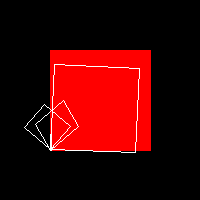

In [79]:
render_transforms(FERN2D)

In [ ]:
render_points(iterate(weighted_random_chooser(FERN2D)))

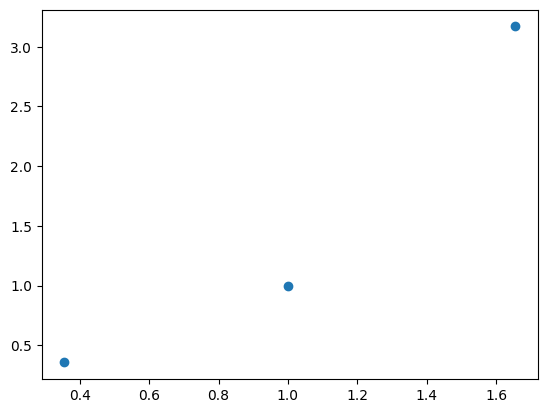

In [47]:
hutch = hutchinson(F, iterate(weighted_random_chooser(FERN2D), 100000))
plt.scatter(hutch[0], hutch[1])
plt.show()

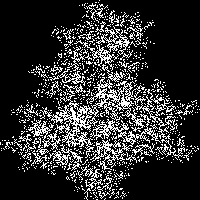

In [8]:
tree_ifs = np.array([[[0.4670822322368622, -0.5178488492965698, 0.02417873963713646],
  [0.5178488492965698, 0.4670822322368622, -0.06665170192718506],
  [0.0, 0.0, 1.0]],
 [[-0.5273969173431396, 0.10378921031951904, 0.03260470926761627],
  [-0.10378921031951904, -0.5273969173431396, 0.18428421020507812],
  [0.0, 0.0, 1.0]],
 [[-0.4779031574726105, 0.33066949248313904, -0.07807090133428574],
  [-0.33066949248313904, -0.4779031574726105, -0.27771109342575073],
  [0.0, 0.0, 1.0]]])
pred_points = iterate(
    weighted_random_chooser(
        tree_ifs,
        determinant_probabilities(FERN2D)[:3]), 
    num_iters=10_000)
render_points(pred_points)


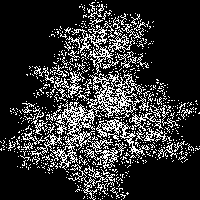

In [9]:
pred_points = iterate(
    weighted_random_chooser(
        tree_ifs,
        determinant_probabilities(tree_ifs)), 
    num_iters=10_000)
render_points(pred_points)

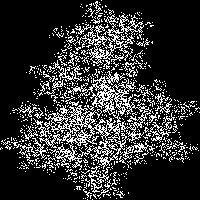

In [12]:
pred_points = iterate(
    weighted_random_chooser(
        tree_ifs,
        np.array([0, 0.9, 0.1])), 
    num_iters=10_000)
render_points(pred_points)

In [76]:
np.average([1, 2], weights=[1.2, -3])

2.6666666666666665